In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yaml
from pandas.tseries import offsets
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullLocator)
import matplotlib.dates as mdates

In [7]:
icij = pd.read_csv('../input/icij-solitary-voices-final-dataset-for-publication.csv.gz', index_col='record_id', parse_dates=['placement_date', 'release_date'], compression='gzip')
icij_not_parsed = pd.read_csv('../input/icij-solitary-voices-final-dataset-for-publication.csv.gz', compression='gzip', index_col='record_id',)

In [8]:
icij.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8488 entries, 1 to 8488
Data columns (total 14 columns):
citizenship             8488 non-null object
citizenship_id          8488 non-null object
facility_aor            8487 non-null object
state                   8488 non-null object
facility                8488 non-null object
facility_id             8488 non-null object
placement_date          8488 non-null datetime64[ns]
year                    8488 non-null int64
placement_reason        8488 non-null object
placement_reason_raw    8488 non-null object
release_date            8293 non-null datetime64[ns]
days_solitary           8293 non-null float64
mental_illness          8488 non-null object
no_suicide_watch        8488 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(10)
memory usage: 994.7+ KB


In [9]:
icij.columns

Index(['citizenship', 'citizenship_id', 'facility_aor', 'state', 'facility',
       'facility_id', 'placement_date', 'year', 'placement_reason',
       'placement_reason_raw', 'release_date', 'days_solitary',
       'mental_illness', 'no_suicide_watch'],
      dtype='object')

In [10]:
icij.head()

,citizenship,citizenship_id,facility_aor,state,facility,facility_id,placement_date,year,placement_reason,placement_reason_raw,release_date,days_solitary,mental_illness,no_suicide_watch
record_id,,,,,,,,,,,,,,
1,Mexico,mexico,PHO (Phoenix),AZ,AZ - Eloy Federal Contract Facility,eloy_federal_contract_facility_az,2012-04-30,2012,Protective Custody: Gang Status (Protective Cu...,protective_custody_gang_status_protective_cust...,2013-06-27,423.0,no,no
2,Sierra Leone,sierra_leone,SLC (Salt Lake City),NV,NV - Henderson Detention Center,henderson_detention_center_nv,2012-05-30,2012,Protective Custody: Criminal Offense,protective_custody_criminal_offense,2013-10-30,518.0,no,no
3,El Salvador,el_salvador,SLC (Salt Lake City),NV,NV - Henderson Detention Center,henderson_detention_center_nv,2012-07-12,2012,Protective Custody: Gang Status (Protective Cu...,protective_custody_gang_status_protective_cust...,2013-03-07,208.0,no,no
4,Iraq,iraq,SND (San Diego),CA,CA - San Diego Contract Detention Facility - C...,san_diego_contract_detention_facility_cca_otay_ca,2012-07-25,2012,Mental Illness,mental_illness,2013-11-13,476.0,yes,no
5,Mexico,mexico,PHO (Phoenix),AZ,AZ - Eloy Federal Contract Facility,eloy_federal_contract_facility_az,2012-08-17,2012,Protective Custody: Criminal Offense,protective_custody_criminal_offense,2013-08-11,448.0,no,no


# Issue with dates

Many records in the ICIJ publication dataset have release dates which precede their placement dates, which is illogical:

In [11]:
release_pre_placement = icij['release_date'] < icij['placement_date']
print(sum(release_pre_placement))

2148


When recalculating solitary length based on published release and placement dates, even more records do not match solitary length as calculated:

In [12]:
mask = ((icij['release_date'] - icij['placement_date']) / np.timedelta64(1, 'D')) == icij['days_solitary']
print(sum(~mask))

5154


Compare a sample of problematic records with unparsed dates in raw dataset to make sure that we didn't misread dates above; appears correct.

In [13]:
sample = icij.loc[~mask, ['placement_date', 'release_date', 'days_solitary']].head()
sample_index = sample.index
sample

,placement_date,release_date,days_solitary
record_id,,,
3,2012-07-12,2013-03-07,208.0
5,2012-08-17,2013-08-11,448.0
6,2012-09-03,2013-02-07,480.0
7,2012-10-12,2013-11-09,275.0
9,2012-11-14,2013-04-11,355.0


In [14]:
not_parsed_sample = icij_not_parsed.loc[sample_index, ['placement_date', 'release_date', 'days_solitary']].head()
not_parsed_sample

,placement_date,release_date,days_solitary
record_id,,,
3,"Jul 12, 2012","Mar 07, 2013",208.0
5,"Aug 17, 2012","Aug 11, 2013",448.0
6,"Sep 03, 2012","Feb 07, 2013",480.0
7,"Oct 12, 2012","Nov 09, 2013",275.0
9,"Nov 14, 2012","Apr 11, 2013",355.0


Here we examine one record where published dates result in miscalculated solitary length. We see that if we swap day and month values in the dates (if day value is 12 or less), the solitary length calculation matches that published by ICIJ:

In [15]:
icij[~mask].head(1)

,citizenship,citizenship_id,facility_aor,state,facility,facility_id,placement_date,year,placement_reason,placement_reason_raw,release_date,days_solitary,mental_illness,no_suicide_watch
record_id,,,,,,,,,,,,,,
3,El Salvador,el_salvador,SLC (Salt Lake City),NV,NV - Henderson Detention Center,henderson_detention_center_nv,2012-07-12,2012,Protective Custody: Gang Status (Protective Cu...,protective_custody_gang_status_protective_cust...,2013-03-07,208.0,no,no


In [16]:
# Dates as published results in solitary length that does not match published data:
print(pd.to_datetime('2013-03-07') - pd.to_datetime('2012-07-12'))
# Dates with reversed day and month values result in correct published solitary length:
print(pd.to_datetime('2013-07-03') - pd.to_datetime('2012-12-07'))

238 days 00:00:00
208 days 00:00:00


Simple function to reformat dates if value of day is 12 or less:

In [17]:
def datefixer(date):
    if date.day <= 12:
        fixed = pd.to_datetime(f'{date.year}-{date.day}-{date.month}')
        return fixed
    elif date.day >= 13:
        fixed = pd.to_datetime(f'{date.year}-{date.month}-{date.day}')
        return fixed
    elif pd.isnull(date):
        fixed = np.nan
        return fixed

Create new fields with fixed dates, recalculate solitary length and compare to ICIJ published solitary length:

In [18]:
icij['placement_date_fixed'] = icij['placement_date'].map(lambda x: datefixer(x))
icij['release_date_fixed'] = icij['release_date'].map(lambda x: datefixer(x))

In [19]:
icij['days_solitary_test'] = (icij['release_date_fixed'] - icij['placement_date_fixed']) / np.timedelta64(1, 'D')

We see that most (but not all) of the issues are resolved:

In [20]:
mask = icij['days_solitary_test'] == icij['days_solitary']
print(sum(~mask))

349


Most of these remaining apparent mismatches are due to null release dates, which makes sense, as `NaN` values do not equate:

In [21]:
sum(icij[~mask]['release_date'].isnull())

195

However in a few cases (approx. 150) `days_solitary` calculation simply seems to be wrong; in these cases for example the year seems to be ignored:

In [22]:
icij[~mask].head(5)

,citizenship,citizenship_id,facility_aor,state,facility,facility_id,placement_date,year,placement_reason,placement_reason_raw,release_date,days_solitary,mental_illness,no_suicide_watch,placement_date_fixed,release_date_fixed,days_solitary_test
record_id,,,,,,,,,,,,,,,,,
69,Mexico,mexico,SND (San Diego),CA,CA - San Diego Contract Detention Facility - C...,san_diego_contract_detention_facility_cca_otay_ca,2013-02-12,2013,Disciplinary,disciplinary,2014-12-30,28.0,no,no,2013-12-02,2014-12-30,393.0
70,Guatemala,guatemala,SND (San Diego),CA,CA - San Diego Contract Detention Facility - C...,san_diego_contract_detention_facility_cca_otay_ca,2013-02-12,2013,Disciplinary,disciplinary,2014-12-30,28.0,no,no,2013-12-02,2014-12-30,393.0
71,Mexico,mexico,SND (San Diego),CA,CA - San Diego Contract Detention Facility - C...,san_diego_contract_detention_facility_cca_otay_ca,2013-02-12,2013,Disciplinary,disciplinary,2014-12-30,28.0,no,no,2013-12-02,2014-12-30,393.0
72,Mexico,mexico,SND (San Diego),CA,CA - San Diego Contract Detention Facility - C...,san_diego_contract_detention_facility_cca_otay_ca,2013-02-12,2013,Disciplinary,disciplinary,2014-12-30,28.0,no,no,2013-12-02,2014-12-30,393.0
73,Honduras,honduras,SND (San Diego),CA,CA - San Diego Contract Detention Facility - C...,san_diego_contract_detention_facility_cca_otay_ca,2013-02-12,2013,Disciplinary,disciplinary,2014-12-31,29.0,no,no,2013-12-02,2014-12-31,394.0


In [23]:
sum(pd.notnull(icij.loc[~mask, 'release_date']))

154

In [24]:
csv_opts = {'sep': '|',
            'quotechar': '"',
            'compression': 'gzip',
            'encoding': 'utf-8'}

In [25]:
icij.to_csv('../frozen/icij-date-fix-temp.csv', **csv_opts)

# Comparing "fixed" ICIJ data with UWCHR data

In [26]:
csv_opts = {'sep': '|',
            'quotechar': '"',
            'compression': 'gzip',
            'encoding': 'utf-8'}

uwchr = pd.read_csv('../input/2018-ICFO-00515 Highlighted_EDIT.csv.gz', parse_dates=['Placement Date', 'Release Date'], **csv_opts)

In [27]:
redacted = ['Alien Number', 'Last Name', 'First Name', 'Date of Birth', 'Path']
uwchr = uwchr.drop(redacted, axis=1)
uwchr.columns = uwchr.columns.str.lower()
uwchr.columns = uwchr.columns.str.replace(' ', '_')
uwchr.columns = uwchr.columns.str.replace('?', '')

In [28]:
nwdc_mask = icij['facility'] == 'WA - Northwest Detention Center '

In [29]:
icij_nwdc = icij[nwdc_mask]

In [30]:
icij_nwdc.reset_index(inplace=True)

In [31]:
print(icij_nwdc['placement_date_fixed'].min())
print(icij_nwdc['placement_date_fixed'].max())

2013-05-13 00:00:00
2017-03-14 00:00:00


In [32]:
print(uwchr['placement_date'].min())
print(uwchr['placement_date'].max())

2013-05-13 00:00:00
2018-05-20 00:00:00


In [33]:
uwchr_annual = uwchr.set_index('placement_date').groupby(pd.Grouper(freq='AS'))
uwchr_fy = uwchr.set_index('placement_date').groupby(pd.Grouper(freq='AS-OCT'))
uwchr_monthly = uwchr.set_index('placement_date').groupby(pd.Grouper(freq='M'))

icij_annual = icij_nwdc.set_index('placement_date_fixed').groupby(pd.Grouper(freq='AS'))
icij_fy = icij_nwdc.set_index('placement_date_fixed').groupby(pd.Grouper(freq='AS-OCT'))
icij_monthly = icij_nwdc.set_index('placement_date_fixed').groupby(pd.Grouper(freq='M'))

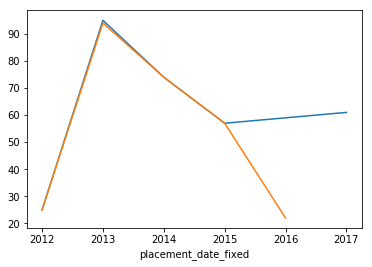

In [34]:
uwchr_fy['tracking_number'].nunique().plot()
icij_fy['record_id'].nunique().plot()

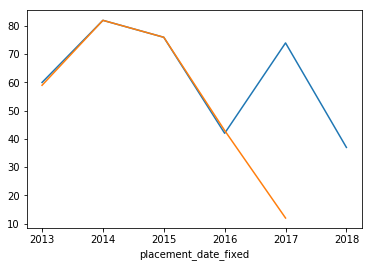

In [35]:
uwchr_annual['tracking_number'].nunique().plot()
icij_annual['record_id'].nunique().plot()

In [36]:
uwchr_monthly_count = uwchr_monthly['tracking_number'].nunique()
uwchr_monthly.name = "UWCHR count"
icij_monthly_count = icij_monthly['record_id'].nunique()
icij_monthly.name = "ICIJ count"
df2 = pd.concat([uwchr_monthly_count, icij_monthly_count], axis=1)

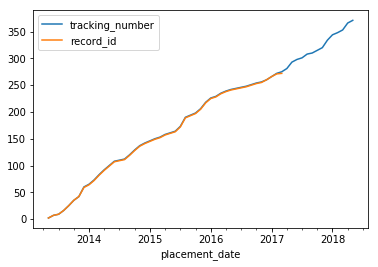

In [37]:
df2.cumsum().plot()

In [38]:
mask = icij_nwdc['release_date_fixed'].isnull()

In [39]:
mask = icij_nwdc.loc[:, 'days_solitary'] == icij_nwdc.loc[:, 'days_solitary_test']

In [40]:
icij_nwdc[~mask].dropna(subset=['release_date'])

,record_id,citizenship,citizenship_id,facility_aor,state,facility,facility_id,placement_date,year,placement_reason,placement_reason_raw,release_date,days_solitary,mental_illness,no_suicide_watch,placement_date_fixed,release_date_fixed,days_solitary_test
49,860,Mexico,mexico,SEA (Seattle),WA,WA - Northwest Detention Center,northwest_detention_center_wa,2013-12-23,2013,Disciplinary,disciplinary,2014-12-30,7.0,yes,no,2013-12-23,2014-12-30,372.0
59,919,Mexico,mexico,SEA (Seattle),WA,WA - Northwest Detention Center,northwest_detention_center_wa,2014-12-31,2013,Disciplinary,disciplinary,2014-01-30,30.0,no,no,2014-12-31,2014-01-30,-335.0
141,2986,Ethiopia,ethiopia,SEA (Seattle),WA,WA - Northwest Detention Center,northwest_detention_center_wa,2015-12-30,2014,Disciplinary,disciplinary,2015-01-22,23.0,no,no,2015-12-30,2015-01-22,-342.0
204,4860,El Salvador,el_salvador,SEA (Seattle),WA,WA - Northwest Detention Center,northwest_detention_center_wa,2015-10-17,2015,Protective Custody: Other Detainee Safety,protective_custody_other_detainee_safety,2016-12-30,74.0,yes,no,2015-10-17,2016-12-30,440.0
217,5396,Mexico,mexico,SEA (Seattle),WA,WA - Northwest Detention Center,northwest_detention_center_wa,2016-12-31,2015,Protective Custody: Other Detainee Safety,protective_custody_other_detainee_safety,2016-01-14,14.0,yes,no,2016-12-31,2016-01-14,-352.0


In [41]:
icij_nwdc.loc[mask, 'days_solitary'].describe()

count    255.000000
mean      52.380392
std       86.309964
min        1.000000
25%       17.000000
50%       27.000000
75%       42.500000
max      781.000000
Name: days_solitary, dtype: float64

In [42]:
icij_nwdc.loc[mask, 'days_solitary_test'].describe()

count    255.000000
mean      52.380392
std       86.309964
min        1.000000
25%       17.000000
50%       27.000000
75%       42.500000
max      781.000000
Name: days_solitary_test, dtype: float64

In [43]:
# Simplify placement reasons into more general categories:
with open(f'../hand/placement-types.yaml', 'r') as yamlfile:
    placement_reason_type = yaml.load(yamlfile)

In [48]:
icij['placement_reason_type'] = icij['placement_reason'].replace(placement_reason_type)

icij = icij[icij['days_solitary'] > 0]

icij['placement_date_fixed'] = pd.to_datetime(icij['placement_date_fixed'])

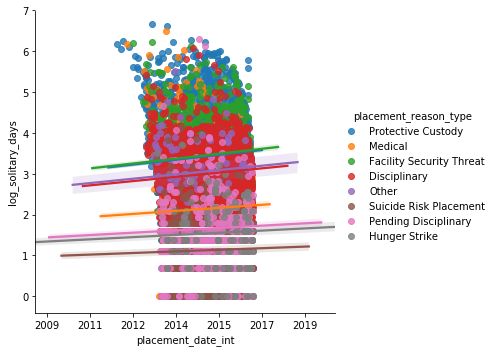

In [49]:
icij = icij.dropna(subset=['release_date'])
icij.loc[:,'placement_date_int'] = icij['placement_date_fixed'].astype(int)
icij.loc[:,'log_solitary_days'] = np.log(icij['days_solitary'])

# x=icij.loc[:, 'placement_date'].astype(int)
# y=icij.loc[:,'log_solitary_days']

lm = sns.lmplot(data=icij, x='placement_date_int', y='log_solitary_days', hue='placement_reason_type')

ax = lm.axes

xticks = ax[0,0].get_xticks()
xticks_dates = [pd.to_datetime(x).year for x in xticks]
ax[0,0].set_xticklabels(xticks_dates);

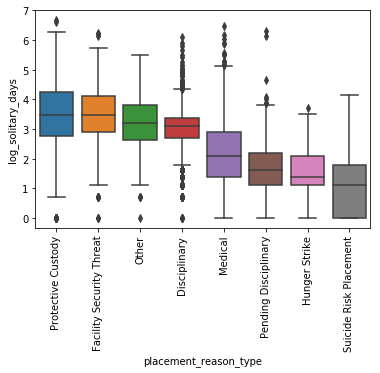

In [50]:
order = icij.groupby(by=["placement_reason_type"])["log_solitary_days"].median().sort_values(ascending=False).index
ax = sns.boxplot(data=icij, x="placement_reason_type", y="log_solitary_days", order=order)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

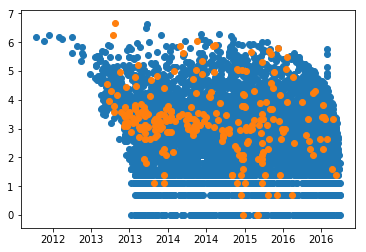

In [52]:
icij_nwdc_str = icij[icij['state'] == 'WA']['facility'].unique()[0]
icij_nwdc_mask = icij.set_index('placement_date_fixed')['facility'] == icij_nwdc_str
icij_nwdc = icij.set_index('placement_date_fixed').loc[icij_nwdc_mask, 'days_solitary'].dropna()
icij_not_nwdc = icij.set_index('placement_date_fixed').loc[~icij_nwdc_mask, 'days_solitary'].dropna()

x=icij_not_nwdc.index.astype(int)
y=np.log(icij_not_nwdc.values)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x, y)

x=icij_nwdc.index.astype(int)
y=np.log(icij_nwdc.values)
plt.scatter(x, y)

xticks = ax.get_xticks()
xticks_dates = [pd.to_datetime(x).year for x in xticks]
ax.set_xticklabels(xticks_dates)
plt.show()
plt.close(fig=fig)
del fig, ax